# Analysis of population and immigration in Catalonia.
Manel Lopez Melia.

## 1. Introduction.

The aim of this project is to study the relation between the shape of the population histograms and the immigration rate of different Catalan cities. It will be determined if a city with younger population has a higher immigration percentage than another.

### Source.

All datasets in this work can be downloaded at https://www.idescat.cat/serveis/consultes/. There are four different datasets:

- 'p2018_municipis_any_any.csv', population of each town in Catalonia for all ages in 1 year bins.
- 'p2018_municipis_quinquenal.csv', population of each town in Catalonia for all ages in 5 years bins.
- 'p2018_municipis_llnaix.csv', population of each town in Catalonia classified by place of birth.
- 'p2018_municipis_nacio.csv', population of each town in Catalonia classified by nationality.

### Packages.

The packages that will be used are:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 2. Exploratory Data Analysis.

The first dataset, 'p2018_municipis_any_any.csv', contains the population of each town in Catalonia in 1 year bins. Executing

!head 'data/p2018_municipis_any_any.csv'

we can skim over the first 10 lines of this file and notice some details, like that the first 3 rows can be skipped or that the separation symbol between columns is ';'. This has to be taken into account when reading the file:

In [2]:
filename = 'data/p2018_municipis_any_any.csv'

indices = ['Municipi', 'Edats']
columns = ['Homes', 'Dones', 'Total']

pop1yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)
pop1yr = pop1yr.set_index(indices)
pop1yr = pop1yr.dropna()

Now this DataFrame can be explored with the typical commands: pop1yr.info(), pop1yr.describe(), pop1yr.head(), pop1yr.tail(), pop1yr.sample().

But let's proceed to more interesting steps and take two subsets of pop1yr: the population of the cities of Barcelona and Olot.

In [3]:
bcntotal = pop1yr.loc[' Barcelona', ' Total']['Total']

bcn1yr = pop1yr.loc[' Barcelona', :]
bcn1yr = bcn1yr.loc[' De 0 anys':' De 100 anys i més']
bcn1yr = bcn1yr / bcntotal * 100

olottotal = pop1yr.loc[' Olot', ' Total']['Total']

olot1yr = pop1yr.loc[' Olot', :]
olot1yr = olot1yr.loc[' De 0 anys':' De 100 anys i més']
olot1yr = olot1yr / olottotal * 100

index = pd.Index([i for i in range(101)])
bcn1yr = bcn1yr.set_index(index)
olot1yr = olot1yr.set_index(index)

print('Barcelona is the capital of Catalonia, with a total population of {:.0f} inhabitants.'.format(bcntotal))
print('Olot is the capital of the county of La Garrotxa, and has {:.0f} inhabitants.'.format(olottotal))

Barcelona is the capital of Catalonia, with a total population of 1620343 inhabitants.
Olot is the capital of the county of La Garrotxa, and has 34486 inhabitants.


The population of both these cities has been scaled to their respective totals. These way, the percentage of each bin can be easily compared:

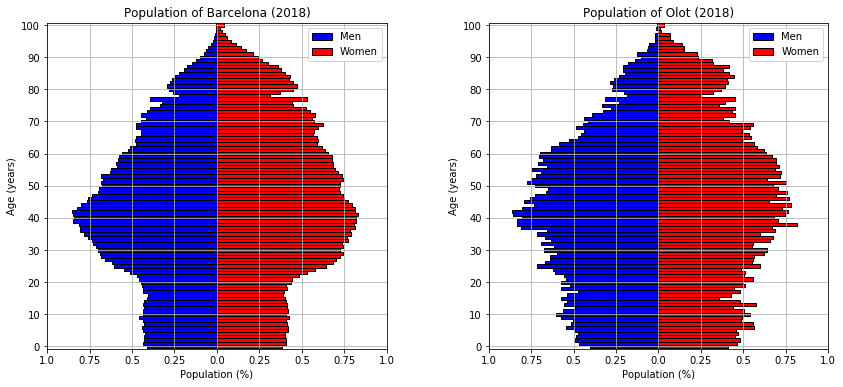

In [4]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

fig.add_subplot(121)
plt.title('Population of Barcelona (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
bcn1yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
bcn1yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
locs = [-1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1.00]
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 101, 10), np.arange(0, 101, 10))
plt.legend()
plt.grid()

fig.add_subplot(122)
plt.title('Population of Olot (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
olot1yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
olot1yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 101, 10), np.arange(0, 101, 10))
plt.legend()
plt.grid()

plt.show()

The purpose of this comparison is to show how the population bins of Olot are far more irregular than those of Barcelona. This is because Barcelona has more inhabitants, around 1.5 M, and Olot only has 35 k, approximately. Just like taking a random sample of some distribution, the bigger your sample, the smoother the distribution.

Now we could focus on the shape of these population pyramids, the baby-boom effect, et cetera, but first, let's find a way to *fix* the problem of these irregularities in Olot's population.

The problem is not Olot itself, as commented, but the fact that it has not enought inhabitants to have smooth statistics. As in this project we will work with almost all towns in Catalonia, we have to find a way to *fix* these irregularities. The solution is simple: gather the bins in groups of 5.

In [5]:
groups_of = 5

mask = np.arange(len(bcn1yr)) // groups_of
bcn5yr = bcn1yr.groupby(mask).sum()
olot5yr = olot1yr.groupby(mask).sum()

array = [str(5*i) + ' to ' + str(5*i + 4) for i in range(20)] + ['100 or +']
index = pd.Index(array)
bcn5yr = bcn5yr.set_index(index)
olot5yr = olot5yr.set_index(index)

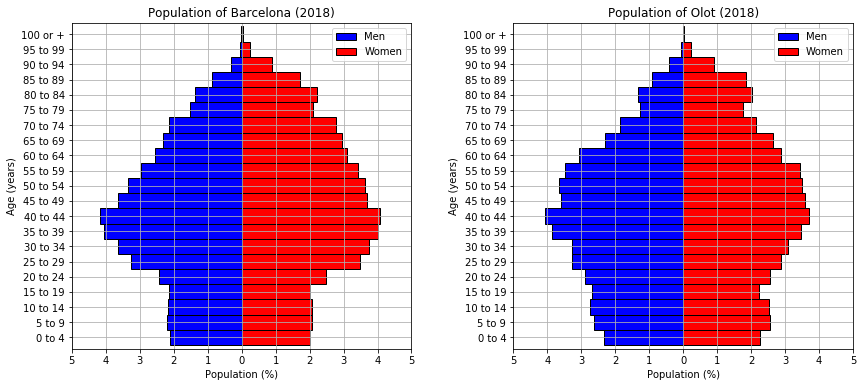

In [6]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

fig.add_subplot(121)
plt.title('Population of Barcelona (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
bcn5yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
bcn5yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
locs = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 21, 1), array)
plt.legend()
plt.grid()

fig.add_subplot(122)
plt.title('Population of Olot (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
olot5yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
olot5yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 21, 1), array)
plt.legend()
plt.grid()

plt.show()

Much better: now we don't have all the information, we lost precision, BUT Olot's population has no noise anymore.

This was to show how one could proceed with a dataset with 1 year bins. In this case, though, we are lucky that there is already a file that contains the population of all towns in Catalonia in 5 year bins:

In [7]:
filename = 'data/p2018_municipis_quinquenal.csv'
indices = ['Municipi', 'Edat']
columns = ['Homes', 'Dones', 'Total']

pop5yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)
pop5yr = pop5yr.set_index(indices)
pop5yr = pop5yr.dropna()

Let's take the Barcelona and Olot subsets again:

In [8]:
bcntotal = pop5yr.loc[' Barcelona', ' Total']['Total']

bcn5yr = pop5yr.loc[' Barcelona', :]
bcn5yr = bcn5yr.loc[' De 0 a 4 anys':' De 100 anys i més']
bcn5yr = bcn5yr / bcntotal * 100

olottotal = pop5yr.loc[' Olot', ' Total']['Total']

olot5yr = pop5yr.loc[' Olot', :]
olot5yr = olot5yr.loc[' De 0 a 4 anys':' De 100 anys i més']
olot5yr = olot5yr / olottotal * 100

array = [str(5*i) + ' to ' + str(5*i + 4) for i in range(20)] + ['100 or +']
index = pd.Index(array)
bcn5yr = bcn5yr.set_index(index)
olot5yr = olot5yr.set_index(index)

and do some plots:

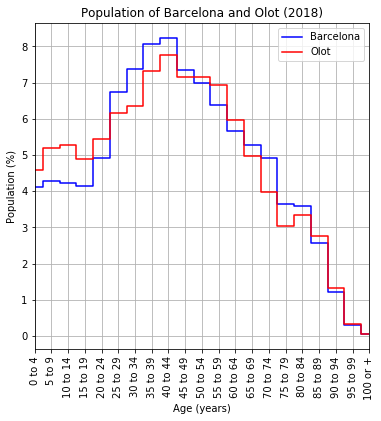

In [9]:
plt.figure(figsize=(6, 6))

plt.title('Population of Barcelona and Olot (2018)')
plt.xlabel('Age (years)')
plt.ylabel('Population (%)')
bcn5yr['Total'].plot(color='blue', drawstyle='steps-mid', label='Barcelona')
olot5yr['Total'].plot(color='red', drawstyle='steps-mid', label='Olot')
plt.xticks(range(len(array)), array, rotation=90)
locs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plt.yticks(locs)
plt.legend()
plt.grid()

plt.show()

Plotted this way, its much easier to compare these two cities.

For instance, it looks like Olot has a greater percentage of population than Barcelona for ages from 0 to 24 years, with differences reaching almost 1%. Does this have relation with the immigration percentage of each city?

To find this percentage of each town in Catalonia, a dataset of the total population of each town has to be taken:

In [10]:
total = pop5yr.loc[(slice(None), ' Total'), 'Total']
total = total.reset_index().drop('Edat', axis=1).set_index('Municipi')
total = total['Total']
total.head()

Municipi
 Abella de la Conca      181.0
 Abrera                12334.0
 Àger                    611.0
 Agramunt               5393.0
 Aguilar de Segarra      277.0
Name: Total, dtype: float64

Now, to find the immigration percentages, we need to use the file 'p2018_municipis_llnaix.csv', which has the population of each town in Catalonia classified depending on their place of birth: the four provincies in Catalonia, namely Barcelona, Girona, Lleida and Tarragona, the sixteen other autonomous communities in Spain, *et cetera*. The column 'Estranger' (abroad) counts how many people of each town has been born abroad of Spain.

In [11]:
filename = 'data/p2018_municipis_llnaix.csv'
indices = ['Municipi', 'Sexe']
columns = ['Estranger']

immigration = pd.read_csv(filename, skiprows=5, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)
immigration = immigration.set_index(indices)
immigration = immigration.loc[(slice(None), ' Total'), :]
immigration = immigration.reset_index().drop('Sexe', axis=1).set_index('Municipi')
immigration = immigration['Estranger']
immigration = immigration.div(total, axis=0)
immigration.head()

Municipi
 Abella de la Conca    0.110497
 Abrera                0.098751
 Àger                  0.132570
 Agramunt              0.169294
 Aguilar de Segarra    0.018051
dtype: float64

We can take all those cities with an immigration percentage higher than 20% and do a mean of their scaled population histograms. We can do the same for the cities with an immigration percentage lower than 20%. This way, we can plot these two histograms together and see how an average city with high immigration rate looks compared to an average city with low immigration rate.

In [12]:
more20 = pop5yr.loc[immigration[immigration > 0.2].index, :]['Total'].div(total[immigration > 0.2]) * 100
less20 = pop5yr.loc[immigration[immigration < 0.2].index, :]['Total'].div(total[immigration < 0.2]) * 100

In [13]:
def moreless(df):
    # only want age bins, not total
    df = df.drop(' Total', level=1)
    
    # translate age index names
    new_index = df.index.levels[1].str.replace(' De ', '').str.replace(' de ', '').str.replace(' a ', ' to ')
    new_index = new_index.str.replace(' anys', '').str.replace(' i més', ' or +')
    df.index = df.index.set_levels(new_index, level=1)
    
    # make age indices to columns and find mean (average over towns)
    df = df.reset_index().pivot(index='Municipi', columns='Edat', values='Total')
    df = df.mean()
    
    # put age indices in order
    df = df.loc[array]
    
    return df

In [14]:
more20 = moreless(more20)
less20 = moreless(less20)

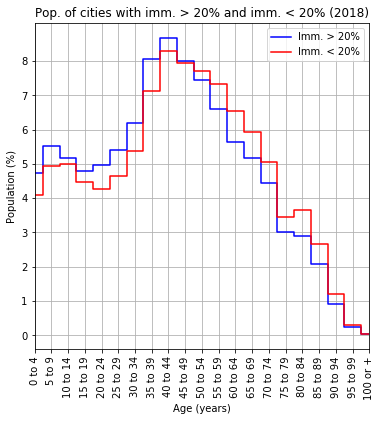

In [15]:
plt.figure(figsize=(6, 6))

more20.plot(color='blue', drawstyle='steps-mid', label='Imm. > 20%')
less20.plot(color='red', drawstyle='steps-mid', label='Imm. < 20%')

plt.title('Pop. of cities with imm. > 20% and imm. < 20% (2018)')
plt.xlabel('Age (years)')
plt.ylabel('Population (%)')
plt.xticks(range(len(array)), array, rotation=90)
locs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plt.yticks(locs)
plt.legend()
plt.grid()

plt.show()

The difference between the two histograms can also be plotted.

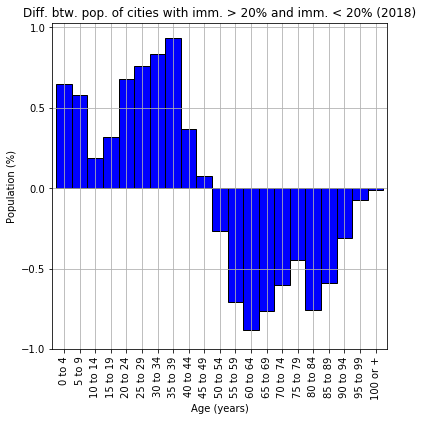

In [16]:
x = more20 - less20

plt.figure(figsize=(6, 6))

x.plot.bar(color='blue', edgecolor='black', width=1)

plt.title('Diff. btw. pop. of cities with imm. > 20% and imm. < 20% (2018)')
plt.xlabel('Age (years)')
plt.ylabel('Population (%)')
plt.xticks(range(len(array)), array, rotation=90)
locs = [-1.0, -0.5, 0, 0.5, 1.0]
plt.yticks(locs)
plt.grid()

plt.show()

The result is quite clear: the average city with high immigration percentage has a younger population than an average city with low immigration rate. In particular, for the intervals from 0 to 50 years, the percentage of population is 0.5% higher, and 0.5% lower for ages from 50 to 100 or more years, approximately.

It looks like it could be related, but this is just a comparison between two average cities. Let's find out if a more sophisticated analysis can be done.

## 3. Linear regression.

The parameter that will be predicted is y, the immigration rate of each town in Catalonia. The predictor will be X, the percentages of each age interval of each town in Catalonia.

That is, **the model will predict the immigration percentage of a town given the *shape* of its population histogram**. Basically, if a town has a younger population than the average, it will be assigned a higher immigration percentage, and *vice versa*.

In [17]:
def prepXy():
    X = pop5yr['Total']
    X = X.div(total, axis=0)
    
    # only want age bins, not total
    X = X.drop(' Total', level=1)
    
    # translate age index names
    new_index = X.index.levels[1].str.replace(' De ', '').str.replace(' de ', '').str.replace(' a ', ' to ')
    new_index = new_index.str.replace(' anys', '').str.replace(' i més', ' or +')
    X.index = X.index.set_levels(new_index, level=1)
    
    # make age indices to columns
    X = X.reset_index().pivot(index='Municipi', columns='Edat', values='Total')
    
    # put age columns in order
    X = X[array]
    
    # immigration rates:
    y = immigration.values
    
    return X, y

In [18]:
def linreg(X, y):

    #X_train, X_test, y_train, y_test = train_test_split(X, y)

    reg = LinearRegression(normalize=True)
    reg.fit(X, y)

    pred = reg.predict(X)

    print('Intercept:', reg.intercept_)
    print('Coefficients:\n', reg.coef_)
    print('Mean squared error: ', mean_squared_error(y, pred))
    print('r2 score: ', r2_score(y, pred))

    lim = max(max(pred), max(y))
    
    # plot
    plt.figure(figsize=(6, 6))

    plt.scatter(pred, y, marker='+', color='red')
    plt.plot([0, lim], [0, lim], linewidth=1, color='blue')
    plt.title('Linear regression: immigration rate')
    plt.xlabel('prediction (%)')
    plt.ylabel('truth (%)')
    plt.xlim([0, lim])
    plt.ylim([0, lim])
    plt.grid()

    plt.show()

Intercept: 1002856871335.1244
Coefficients:
 [-1.00285687e+12 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12
 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12
 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12
 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12
 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12 -1.00285687e+12
 -1.00285687e+12]
Mean squared error:  0.004366021761429304
r2 score:  0.030905637932497454


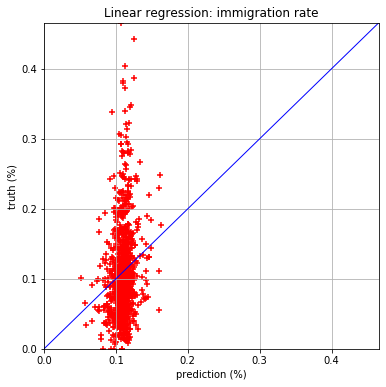

In [19]:
X, y = prepXy()

# do linear regression
linreg(X, y)

The problem with the model above is the presence of very small villages amongst the data: indeed, some little villages don't even have immigration and the *shapes* of their population histograms is very irregular. This is the reason why the minimization gives infinity for the intercept and -infinity for the coefficients.

By applying a good mask, only cities with high population are studied and a better model is obtained.

/home/mlopez13/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Intercept: -0.45946692002891254
Coefficients:
 [ -6.47981008   5.20351967  -5.36908231   4.37746281   2.11906398
   8.9246561  -10.8225811   15.86435904  -1.85077645  -4.11758073
   9.0735329   -9.8009959   -5.73462313   9.92941608 -15.71553708
   4.3430862   16.99711671   0.28126365 -49.80761154 160.96833154
 -42.61317388]
Mean squared error:  0.00034384328032784073
r2 score:  0.881116636443144


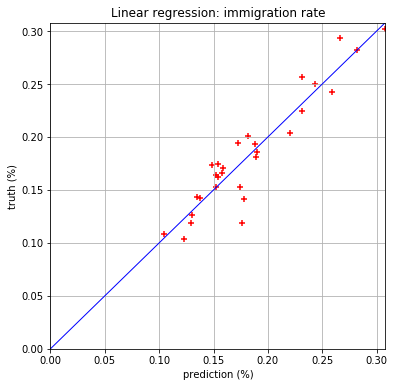

In [20]:
mask = total > 40000

X, y = prepXy()

# apply mask
X = X[mask]
y = y[mask]

# do linear regression
linreg(X, y)

The $r^2$ score is over 0.8, which is very good having in mind that this is human science. However, there are only

In [21]:
np.sum(mask)

29

points considered.

Also, looking at the coefficients, it looks like the hypothesis made is not fulfiled here: we were expecting to obtain positive slopes for the first coefficients and negative for the last because, as we assumed, the younger the population, the higher the immigration rate. However, the obtained coefficients have alternating signs. Maybe this is due to overfitting.